# 推荐系统 Recommendation System

在这个项目中，我们将使用音乐数据集来构建推荐系统，主要通过矩阵分解方法来实现音乐推荐。

## 音乐数据处理 Music Data Processing
- 读取并分析音乐数据集，统计各项指标。
- 筛选有价值的信息作为特征进行后续处理。

## 基于商品相似性的推荐 Item-based Recommendation
- 选取适合的相似度计算方法，如余弦相似度或欧氏距离。
- 基于计算得到的相似度进行音乐推荐。

## 基于SVD矩阵分解的推荐 SVD-based Recommendation
- 应用SVD（奇异值分解）方法进行矩阵分解。
- 基于分解结果快速高效地生成推荐列表。

通过对音乐数据集进行深入分析和特征提取，并结合矩阵分解技术，我们可以构建一个能够提供精准音乐推荐的系统。

In this project, we will build a recommendation system using a music dataset, primarily utilizing matrix factorization methods for music recommendations.

## Music Data Processing
- Read and analyze the music dataset, and calculate various metrics.
- Select valuable information as features for subsequent processing.

## Item-based Recommendation
- Choose an appropriate similarity calculation method, such as cosine similarity or Euclidean distance.
- Recommend music based on calculated similarities.

## SVD-based Recommendation
- Apply Singular Value Decomposition (SVD) for matrix factorization.
- Efficiently generate a recommendation list based on the factorization results.

By conducting in-depth analysis and feature extraction on the music dataset and combining matrix factorization techniques, we can build a system capable of providing accurate music recommendations.

In [1]:
#导入相关库
import pandas as pd
import numpy as np
import time
import sqlite3
data_home = './'
triplet_dataset = pd.read_csv(filepath_or_buffer = data_home + 'train_triplets.txt', sep = '\t', header = None, names = ['user', 'song', 'play_count'])
triplet_dataset.shape
triplet_dataset.info()

(48373586, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        object
 1   song        object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


In [2]:
#查看数据
triplet_dataset.head(10)
#提取数据中有关用户和歌曲的指标
output_dict = {}
with open(data_home + 'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #获取用户信息
        user = line.split('\t')[0]
        #获取用户播放量数据
        play_count = int(line.split('\t')[2])
        #如果已经有该用户，在此基础上增加当前播放量
        if user in output_dict:
            play_count += output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})

#统计数据
output_list = [{'user': k, 'play_count': v} for k,v in output_dict.items()]
play_count_df = pd.DataFrame(output_list)
play_count_df = play_count_df.sort_values(by = 'play_count', ascending = False)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [3]:
#保存数据以免出错
play_count_df.to_csv(path_or_buf='user_playcount_df.csv', index = False)

In [4]:
#统计方法跟上述类似
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #找到当前歌曲
        song = line.split('\t')[1]
        #找到当前播放次数
        play_count = int(line.split('\t')[2])
        #统计每首歌曲被播放的总次数
        if song in output_dict:
            play_count +=output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
#转换成df格式
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by = 'play_count', ascending = False)

In [5]:
song_count_df.to_csv(path_or_buf='song_playcount_df.csv', index = False)

In [6]:
#查看数据
play_count_df.head(10)
song_count_df.head(10)

,user,play_count
669980,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
402687,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
964856,3fa44653315697f42410a30cb766a4eb102080bb,8210
462404,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
991089,d7d2d888ae04d16e994d6964214a1de81392ee04,6494
234384,4ae01afa8f2430ea0704d502bc7b57fb52164882,6472
824276,b7c24f770be6b802805ac0e2106624a517643c17,6150
225988,113255a012b2affeab62607563d03fbdf31b08e7,5656
30701,6d625c6557df84b60d90426c0116138b617b9449,5620
355770,99ac3d883681e21ea68071019dba828ce76fe94d,5602


,song,play_count
202,SOBONKR12A58A7A7E0,726885
199,SOAUWYT12A81C206F1,648239
218,SOSXLTC12AF72A7F54,527893
22,SOFRQTD12A81C233C0,425463
206,SOEGIYH12A6D4FC0E3,389880
200,SOAXGDH12A8C13F8A1,356533
214,SONYKOW12AB01849C9,292642
1824,SOPUCYA12A8C13A694,274627
5017,SOUFTBI12AB0183F65,268353
222,SOVDSJC12A58A7A271,244730


In [7]:
#预计要截取的数据比例
total_play_count = sum(song_count_df.play_count)
print((float(play_count_df.head(100000).play_count.sum()) / total_play_count) * 100)
(float(song_count_df.head(n=30000).play_count.sum())/total_play_count)*100
#截取副本数据
play_count_subset = play_count_df.head(n=100000)
song_count_subset = song_count_df.head(n=30000)

40.8807280500655


78.39315366645269

In [8]:
#获取副本数据
user_subset = play_count_subset['user'].tolist()
song_subset = song_count_subset['song'].tolist()

#读取原始数据集并保留过滤后的数据
triplet_dataset = pd.read_csv(filepath_or_buffer = data_home + 'train_triplets.txt', sep = '\t', header = None, names = ['user', 'song', 'play_count'])
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset)]
del(triplet_dataset)
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub)
#保存结果
triplet_dataset_sub_song.to_csv(path_or_buf = data_home + 'triplet_dataset_sub_song.csv', index = False)

In [9]:
triplet_dataset_sub_song.shape

(10774558, 3)

In [10]:
# 通过sqlite3读取歌曲详细信息
conn = sqlite3.connect(data_home + 'track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

track_metadata_df = pd.read_sql(con=conn, sql='SELECT * FROM songs')
track_metadata_df_sub = track_metadata_df[track_metadata_df['song_id'].isin(song_subset)]
# 保存临时文件
track_metadata_df_sub.to_csv(path_or_buf=data_home + 'track_metadata_df_sub.csv', index=False)

[('songs',)]

In [11]:
track_metadata_df_sub.shape

(30447, 14)

In [12]:
#读取我们现有的数据
import pandas as pd
triplet_dataset_sub_song = pd.read_csv(filepath_or_buffer=data_home+'triplet_dataset_sub_song.csv',encoding = "ISO-8859-1")
track_metadata_df_sub = pd.read_csv(filepath_or_buffer=data_home+'track_metadata_df_sub.csv',encoding = "ISO-8859-1")
triplet_dataset_sub_song.head()
track_metadata_df_sub.head()

,user,song,play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
1,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
2,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
3,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
4,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


In [13]:
# 去掉无用的信息
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])
# 去掉重复的
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])
# 将这份音乐信息数据和我们之前的播放数据整合到一起
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song, track_metadata_df_sub, how='left', left_on='song', right_on='song_id')
# 可以自己改变列名
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)
# 去掉不需要的指标
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

<BarContainer object of 20 artists>

([<matplotlib.axis.XTick at 0x305f5b610>,
 [Text(0, 0, "You're The One"),
  Text(1, 0, 'Undo'),
  Text(2, 0, 'Revelry'),
  Text(3, 0, 'Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)'),
  Text(4, 0, 'Sehr kosmisch'),
  Text(5, 0, 'Dog Days Are Over (Radio Edit)'),
  Text(6, 0, 'Canada'),
  Text(7, 0, 'Invalid'),
  Text(8, 0, 'Secrets'),
  Text(9, 0, 'Catch You Baby (Steve Pitron & Max Sanna Radio Edit)'),
  Text(10, 0, 'ReprÃ©sente'),
  Text(11, 0, "Ain't Misbehavin"),
  Text(12, 0, 'SinceritÃ© Et Jalousie'),
  Text(13, 0, 'The Gift'),
  Text(14, 0, 'Hey_ Soul Sister'),
  Text(15, 0, 'Fireflies'),
  Text(16, 0, "I CAN'T GET STARTED"),
  Text(17, 0, 'Marry Me'),
  Text(18, 0, 'Tive Sim'),
  Text(19, 0, 'Use Somebody')])

Text(0.5, 1.0, 'Most Popular Songs Top20')

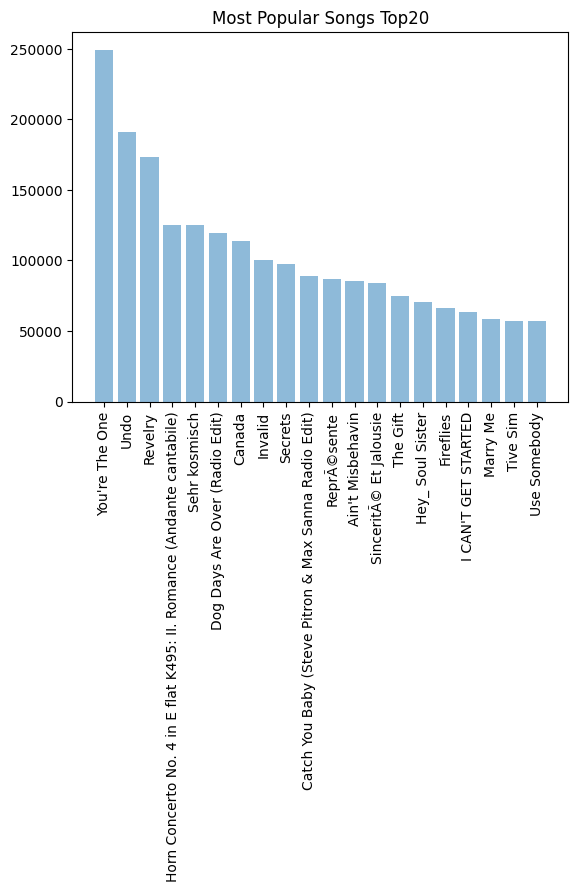

In [14]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
#按照歌曲名字来统计播放量总数
popular_songs = triplet_dataset_sub_song_merged[['title','listen_count']].groupby('title').sum().reset_index()
#对结果排序
popular_songs_top_20 = popular_songs.sort_values('listen_count', ascending = False).head(20)
#转换成list格式方便可视化
objects = (list(popular_songs_top_20['title']))
#设置可视化
y_pos = np.arange(len(objects))
performance = list(popular_songs_top_20['listen_count'])
plt.bar(y_pos, performance, align = "center", alpha = 0.5)
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.title('Most Popular Songs Top20')
plt.show()

<BarContainer object of 20 artists>

([<matplotlib.axis.XTick at 0x381ee09d0>,
 [Text(0, 0, 'Coldplay'),
  Text(1, 0, 'The Black Keys'),
  Text(2, 0, 'Kings Of Leon'),
  Text(3, 0, 'Florence + The Machine'),
  Text(4, 0, 'Jack Johnson'),
  Text(5, 0, 'Dwight Yoakam'),
  Text(6, 0, 'Muse'),
  Text(7, 0, 'BjÃ¶rk'),
  Text(8, 0, 'The Killers'),
  Text(9, 0, 'Radiohead'),
  Text(10, 0, 'OneRepublic'),
  Text(11, 0, 'Alliance Ethnik'),
  Text(12, 0, 'Linkin Park'),
  Text(13, 0, 'Train'),
  Text(14, 0, 'Daft Punk'),
  Text(15, 0, 'Metallica'),
  Text(16, 0, 'Rise Against'),
  Text(17, 0, 'John Mayer'),
  Text(18, 0, 'Justin Bieber'),
  Text(19, 0, 'Eminem')])

Text(0.5, 1.0, 'Most Popular Artists Top20')

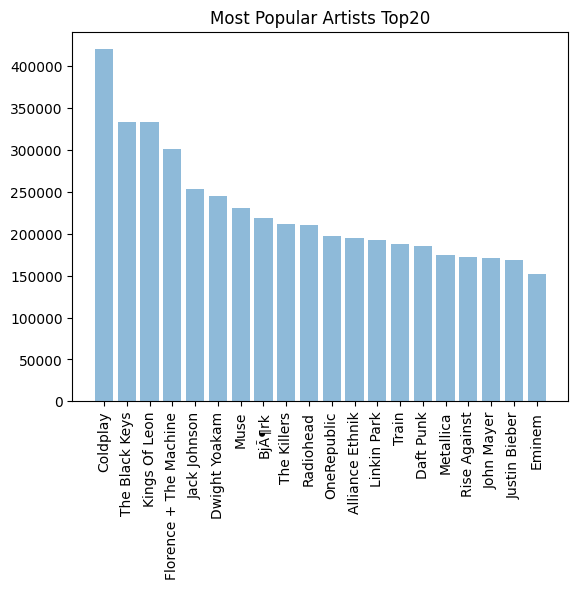

In [15]:
#按歌手来统计歌曲播放量
popular_artist = triplet_dataset_sub_song_merged[['artist_name', 'listen_count']].groupby('artist_name').sum().reset_index()
#排序
popular_artist_top_20 = popular_artist.sort_values('listen_count', ascending = False).head(20)
objects = (list(popular_artist_top_20['artist_name']))
y_pos = np.arange(len(objects))
performance = list(popular_artist_top_20['listen_count'])
#绘图
plt.bar(y_pos, performance, align = "center", alpha = 0.5)
plt.xticks(y_pos, objects, rotation = 'vertical')
plt.title('Most Popular Artists Top20')
plt.show()

,title
count,99996.000000
mean,107.749890
std,79.742561
min,1.000000
25%,53.000000
50%,89.000000
75%,141.000000
max,1189.000000


Text(0.5, 0, 'Play Counts')

Text(0, 0.5, 'Num of Users')

Text(0.5, 1.0, '$\\mathrm{Histogram\\ of\\ User\\ Play\\ Count\\ Distribution}\\ $')

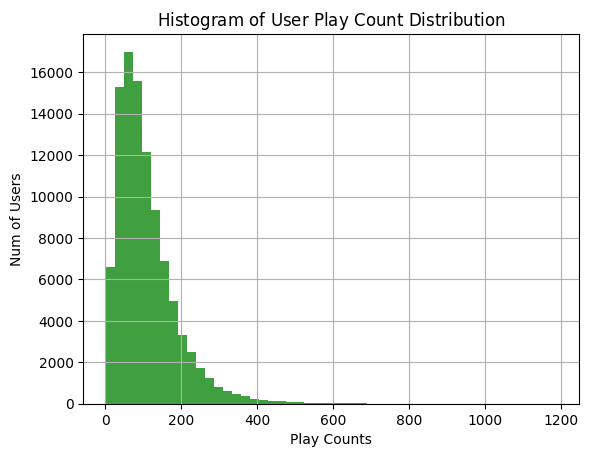

In [16]:
#查看平台用户播放量分布
user_song_count_distribution = triplet_dataset_sub_song_merged[['user', 'title']].groupby('user').count().reset_index().sort_values(by = 'title', ascending = False)
user_song_count_distribution.describe()
#可视化
x = user_song_count_distribution.title
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'$\mathrm{Histogram\ of\ User\ Play\ Count\ Distribution}\ $')
plt.grid(True)
plt.show()

In [17]:
#创建排行榜推荐函数
def create_popularity_recommendation(train_data, user_id, item_id):
    #根据指定特征统计播放情况，可选歌曲名、专辑名、歌手名
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    #用得分代替结果
    train_data_grouped.rename(columns = {user_id: "score"}, inplace = True)
    #排序排行榜
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    #加入排行等级表示优先级
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending = 0, method = 'first')
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged, 'user', 'title')
recommendations.head(20)

,title,score,Rank
19580,Sehr kosmisch,18626,1.0
5780,Dog Days Are Over (Radio Edit),17635,2.0
27314,You're The One,16085,3.0
19542,Secrets,15138,4.0
18636,Revelry,14945,5.0
25070,Undo,14687,6.0
7530,Fireflies,13085,7.0
9640,Hey_ Soul Sister,12993,8.0
25216,Use Somebody,12793,9.0
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


In [18]:
#基于相似度推荐
from sklearn.model_selection import train_test_split
#读取数据
song_count_df = pd.read_csv('./song_playcount_df.csv')
play_count_df = pd.read_csv('./user_playcount_df.csv')
song_count_subset = song_count_df.head(n=5000)
play_count_subset = play_count_df.head(n=5000)
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)
triplet_dataset_sub_song_merged_sub = triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]

In [19]:
#相似度计算,利用Recommers.py的函数实现，具体参考里面的实例代码
import Recommenders as Recommenders
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_sub, test_size = 0.3, random_state=77)
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user', 'title')
user_id = list(train_data.user)[7]
user_items = is_model.get_user_items(user_id)
is_model.recommend(user_id)

No. of unique songs for the user: 34
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :152438


,user_id,song,score,rank
0,74ff16690918607e49160361dcc064b3982c7a66,West One (Shine On Me),0.033666,1
1,74ff16690918607e49160361dcc064b3982c7a66,Keep It Loose_ Keep It Tight,0.032869,2
2,74ff16690918607e49160361dcc064b3982c7a66,Black River,0.031280,3
3,74ff16690918607e49160361dcc064b3982c7a66,Undo,0.030856,4
4,74ff16690918607e49160361dcc064b3982c7a66,Revelry,0.030559,5
5,74ff16690918607e49160361dcc064b3982c7a66,Canada,0.029167,6
6,74ff16690918607e49160361dcc064b3982c7a66,Horn Concerto No. 4 in E flat K495: II. Romanc...,0.028607,7
7,74ff16690918607e49160361dcc064b3982c7a66,ReprÃ©sente,0.028206,8
8,74ff16690918607e49160361dcc064b3982c7a66,Dog Days Are Over (Radio Edit),0.027779,9
9,74ff16690918607e49160361dcc064b3982c7a66,Secrets,0.027722,10


In [20]:
#SVD算法计算相似度
#提取数据
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user', 'listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count': 'total_listen_count'}, inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged, triplet_dataset_sub_song_merged_sum_df, on='user')
triplet_dataset_sub_song_merged.head()
#计算比例
triplet_dataset_sub_song_merged['fractional_play_count'] = triplet_dataset_sub_song_merged['listen_count'] / triplet_dataset_sub_song_merged['total_listen_count']
triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.user =='d6589314c0a9bcbca4fee0c93b14bc402363afea'][['user','song','listen_count','fractional_play_count']].head()

,user,song,listen_count,title,release,artist_name,year,total_listen_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004,329
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007,329
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0,329
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993,329
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329


,user,song,listen_count,fractional_play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.036474
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003040
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003040
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003040
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.021277


In [23]:
#构建SVD所需的矩阵
from scipy.sparse import coo_matrix
small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'},inplace=True)
song_codes.rename(columns={'index':'song_index'},inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how = 'left')
small_set = pd.merge(small_set,user_codes,how = 'left')
mat_candidate = small_set[['us_index_value', 'so_index_value', 'fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values
data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)
#计算SVD分解矩阵
import math as mt
from scipy.sparse.linalg import svds
from scipy.sparse.linalg import * #为了矩阵乘法
from scipy.sparse import csc_matrix
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)
    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(len(s)):
        S[i, i] = mt.sqrt(s[i])
    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    return U, S, Vt
K = 50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]
U, S, Vt = compute_svd(urm, K)


In [25]:
#查看预测结果
def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
for user in uTest:
    print("当前待推荐用户编号 {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("推荐编号： {} 推荐歌曲： {} 作者： {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

当前待推荐用户编号 4
推荐编号： 1 推荐歌曲： Fireflies 作者： Charttraxx Karaoke
推荐编号： 2 推荐歌曲： Hey_ Soul Sister 作者： Train
推荐编号： 3 推荐歌曲： OMG 作者： Usher featuring will.i.am
推荐编号： 4 推荐歌曲： Lucky (Album Version) 作者： Jason Mraz & Colbie Caillat
推荐编号： 5 推荐歌曲： Vanilla Twilight 作者： Owl City
推荐编号： 6 推荐歌曲： Crumpshit 作者： Philippe Rochard
推荐编号： 7 推荐歌曲： Billionaire [feat. Bruno Mars]  (Explicit Album Version) 作者： Travie McCoy
推荐编号： 8 推荐歌曲： Love Story 作者： Taylor Swift
推荐编号： 9 推荐歌曲： TULENLIEKKI 作者： M.A. Numminen
推荐编号： 10 推荐歌曲： Use Somebody 作者： Kings Of Leon
当前待推荐用户编号 5
推荐编号： 1 推荐歌曲： Sehr kosmisch 作者： Harmonia
推荐编号： 2 推荐歌曲： Ain't Misbehavin 作者： Sam Cooke
推荐编号： 3 推荐歌曲： Dog Days Are Over (Radio Edit) 作者： Florence + The Machine
推荐编号： 4 推荐歌曲： Revelry 作者： Kings Of Leon
推荐编号： 5 推荐歌曲： Undo 作者： BjÃ¶rk
推荐编号： 6 推荐歌曲： Cosmic Love 作者： Florence + The Machine
推荐编号： 7 推荐歌曲： Home 作者： Edward Sharpe & The Magnetic Zeros
推荐编号： 8 推荐歌曲： You've Got The Love 作者： Florence + The Machine
推荐编号： 9 推荐歌曲： Bring Me To Life 作者： Evanescence
推荐编号： 10 推荐歌曲： T